# 3D Alexandria Database


![alexandria_3d](images/alexandria_3d_database.png)

In [ ]:
!pip install parquetdb
!pip install pymatgen

In [1]:
import json
import os
import logging
from glob import glob
import shutil
import time

import numpy as np
from pyarrow import compute as pc

from parquetdb.core.parquetdb import LoadConfig, NormalizeConfig
from parquetdb.utils.general_utils import timeit
from parquetdb import ParquetDB, config
from parquetdb.utils.external_utils import download_alexandria_3d_database

import matplotlib.pyplot as plt

## Setup

### Setup data directories

In [2]:
base_dir = os.path.join(config.data_dir, "external", "alexandria", "AlexandriaDB")
benchmark_dir = os.path.join(config.data_dir, "benchmarks", "alexandria")

### Download the database

Lets download the database

In [3]:
def download_alexandria_database(base_dir, from_scratch=False):
    print("Starting task: download_alexandria_database")
    if from_scratch and os.path.exists(base_dir):
        print(f"Removing existing directory: {base_dir}")
        shutil.rmtree(base_dir, ignore_errors=True)

    # Here we download the database and save it to the data directory
    output_dir = os.path.join(config.data_dir, "external", "alexandria")
    alexandria_dir = download_alexandria_3d_database(output_dir, n_cores=8)
    print("Done with task: download_alexandria_database")
    print("-" * 200)
    return alexandria_dir


alexandria_dir = download_alexandria_database(base_dir, from_scratch=False)
print(alexandria_dir)

Starting task: download_alexandria_database
Database downloaded already. Skipping download.
Done with task: download_alexandria_database
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Z:\data\parquetdb\data\external\alexandria\uncompressed


## Creating the database


In [4]:
db = ParquetDB(db_path=os.path.join(base_dir, "alexandria_3D"))
print(db)

[INFO] 2025-04-22 09:14:49 - parquetdb.core.parquetdb[205][__init__] - Initializing ParquetDB with db_path: Z:\data\parquetdb\data\external\alexandria\AlexandriaDB\alexandria_3D
[INFO] 2025-04-22 09:14:49 - parquetdb.core.parquetdb[207][__init__] - verbose: 1
PARQUETDB SUMMARY
Database path: Z:\data\parquetdb\data\external\alexandria\AlexandriaDB\alexandria_3D

• Number of columns: 128
• Number of rows: 4389295
• Number of files: 1
• Number of rows per file: [4389295]
• Number of row groups per file: [22]
• Serialized metadata size per file: [377883] Bytes

############################################################
METADATA
############################################################

############################################################
COLUMN DETAILS
############################################################



Lets Define some dictionaries to store some benchmark results


In [5]:
benchmark_dict = {
    "create_times": [],
    "json_load_times": [],
    "n_rows_per_file": [],
}

task_benchmark_dict = {"task_names": [], "task_times": []}

### Inputing the data

Here I am just iterating over the json files and creating the database. I am also storing how long it takes to load each json file, how many materials, and how long it takes to input the data into the database.

This dataset is rather large, so you may have to choose the normalization parameters depending on how much RAM you have. If you do not have enough tweak the `batch_size`, `batch_readahead`, `fragment_readahead` parameters.


In [6]:
def create_database_if_empty(db, alexandria_dir, normalize_config=NormalizeConfig()):
    """_summary_

    Parameters
    ----------
    db : ParquetDB Instance
        The database instance to create the dataset on.
    alexandria_dir : str
        The directory containing the json files to input into the database.

    Returns
    -------
    _type_
        _description_
    """
    print("Starting task: create_database_if_empty")

    start_time = time.time()

    json_load_times = []
    create_times = []
    n_materials_per_file = []
    if db.is_empty():
        print("The dataset does not exist. Creating it.")
        json_files = glob(os.path.join(alexandria_dir, "*.json"))
        for json_file in json_files[:]:

            start_time = time.time()
            with open(json_file, "r") as f:
                data = json.load(f)
            json_load_time = time.time() - start_time

            base_name = os.path.basename(json_file)
            n_materials = len(data["entries"])
            print(f"Processing file: {base_name}")
            print(f"Number of materials: {n_materials}")
            try:
                # Since we are importing alot of data it is best
                # to normalize the database afterwards
                start_time = time.time()
                db.create(
                    data["entries"],
                    normalize_dataset=False,
                    normalize_config=normalize_config,
                )
                create_time = time.time() - start_time

                create_times.append(create_time)
                n_materials_per_file.append(n_materials)
                json_load_times.append(json_load_time)

            except Exception as e:
                print(e)

            data = None

            print(f"Time taken to create dataset: {time.time() - start_time}")
            print("-" * 100)

    print("Done with task: create_database_if_empty")
    print("-" * 200)
    return json_load_times, create_times, n_materials_per_file


normalize_config = NormalizeConfig(
    load_format="batches",  # Uses the batch generator to normalize
    batch_readahead=4,  # Controls the number of batches to load in memory a head of time. This will have impacts on amount of RAM consumed
    fragment_readahead=2,  # Controls the number of files to load in memory ahead of time. This will have impacts on amount of RAM consumed
    batch_size=100000,  # Controls the batchsize when to use when normalizing. This will have impacts on amount of RAM consumed
    max_rows_per_file=100000,  # Controls the max number of rows per parquet file
    max_rows_per_group=100000,
)  # Controls the max number of rows per group parquet


json_load_times, create_times, n_materials_per_file = create_database_if_empty(
    db, alexandria_dir, normalize_config=normalize_config
)

benchmark_dict["create_times"] = create_times
benchmark_dict["json_load_times"] = json_load_times
benchmark_dict["n_rows_per_file"] = n_materials_per_file

Starting task: create_database_if_empty
Done with task: create_database_if_empty
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


## Normalizing the dataset

It is best practive to normalize the dataset after all the data has been inputed. This will optimize the performance of the database.

First let's see how the data is distributed in the row groups.


In [7]:
summary = db.summary(show_row_group_metadata=True)
print(summary)

PARQUETDB SUMMARY
Database path: Z:\data\parquetdb\data\external\alexandria\AlexandriaDB\alexandria_3D

• Number of columns: 128
• Number of rows: 4389295
• Number of files: 1
• Number of rows per file: [4389295]
• Number of row groups per file: [22]
• Number of rows per row group per file: 
    - alexandria_3D_0.parquet:
        - Row group 0: 200000 rows
        - Row group 1: 200000 rows
        - Row group 2: 200000 rows
        - Row group 3: 200000 rows
        - Row group 4: 200000 rows
        - Row group 5: 200000 rows
        - Row group 6: 200000 rows
        - Row group 7: 200000 rows
        - Row group 8: 200000 rows
        - Row group 9: 200000 rows
        - Row group 10: 200000 rows
        - Row group 11: 200000 rows
        - Row group 12: 200000 rows
        - Row group 13: 200000 rows
        - Row group 14: 200000 rows
        - Row group 15: 200000 rows
        - Row group 16: 200000 rows
        - Row group 17: 200000 rows
        - Row group 18: 200000 rows
  

Let's check the file size of the parquet files.

In [8]:
def list_file_sizes(directory, in_MB=True):
    """Lists the size of files in a directory.

    Args:
      directory: The path to the directory.
    """
    file_sizes = {}
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path):
            file_size = os.path.getsize(file_path)
            if in_MB:
                file_size = file_size / (1024 * 1024)
            file_sizes[filename] = file_size
    return file_sizes


file_sizes = list_file_sizes(db.db_path)

for file, size in file_sizes.items():
    print(f"{file}: {size} MB")

alexandria_3D_0.parquet: 2767.1490955352783 MB


Let's also check the size of the row groups.



In [9]:
row_group_metadata_per_file = db.get_parquet_file_row_group_metadata_per_file(
    as_dict=True
)
row_group_size_per_file = {}
sum_row_group_size = 0
num_row_groups = 0
for file, row_group_metadata in row_group_metadata_per_file.items():
    print(f"{file}")
    row_group_size_per_file[file] = {}
    for row_group, metadata in row_group_metadata.items():
        row_group_size_per_file[file][row_group] = metadata["total_byte_size"] / (
            1024 * 1024
        )
        sum_row_group_size += row_group_size_per_file[file][row_group]
        num_row_groups += 1
        print(f"     {row_group}: {row_group_size_per_file[file][row_group]} MB")

print(f"Average row group size: {sum_row_group_size/num_row_groups} MB")

alexandria_3D_0.parquet
     0: 201.08054542541504 MB
     1: 220.59319686889648 MB
     2: 197.38053512573242 MB
     3: 187.26845264434814 MB
     4: 227.97186374664307 MB
     5: 192.6089096069336 MB
     6: 216.52346420288086 MB
     7: 198.00727558135986 MB
     8: 227.92319583892822 MB
     9: 226.87678337097168 MB
     10: 244.66320514678955 MB
     11: 215.52607440948486 MB
     12: 198.7313060760498 MB
     13: 204.19597339630127 MB
     14: 192.36825561523438 MB
     15: 217.40732860565186 MB
     16: 215.3526430130005 MB
     17: 201.5632438659668 MB
     18: 189.40394115447998 MB
     19: 200.09145641326904 MB
     20: 208.74722480773926 MB
     21: 206.02736282348633 MB
Average row group size: 208.65055626088923 MB


For the most optimal performance we should aim for 2GB per file and about 200-500MB per row group.

Currently for a row group with 32,768 rows the size of the row group is ~30MB. To get to 200MB we should put 200MB/30MB more rows in the row group or ~200,000 rows.

If each rowgroup is about 200MB at 200,000 rows then we should have 2GB/200MB = 10 row groups per file. or 2,000,000 rows per file. 

In [10]:
def normalize_dataset(db, normalize_config=NormalizeConfig()):
    task_name = "normalize_dataset"
    print("Starting task: normalize_dataset")

    db.normalize(normalize_config=normalize_config)
    print("Done with task: normalize_dataset")
    print("-" * 200)
    return task_name


normalize_config = NormalizeConfig(
    load_format="batches",  # Uses the batch generator to normalize
    batch_readahead=4,  # Controls the number of batches to load in memory a head of time. This will have impacts on amount of RAM consumed
    fragment_readahead=1,  # Controls the number of files to load in memory ahead of time. This will have impacts on amount of RAM consumed
    batch_size=10000,  # Controls the batchsize when to use when normalizing. This will have impacts on amount of RAM consumed
    max_rows_per_file=2000000,  # Controls the max number of rows per parquet file
    max_rows_per_group=200000,
    min_rows_per_group=200000,
)  # Controls the max number of rows per group parquet file
normalize_dataset(db, normalize_config=normalize_config)
print(db.summary(show_row_group_metadata=True))

Starting task: normalize_dataset
Done with task: normalize_dataset
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
PARQUETDB SUMMARY
Database path: Z:\data\parquetdb\data\external\alexandria\AlexandriaDB\alexandria_3D

• Number of columns: 128
• Number of rows: 4389295
• Number of files: 3
• Number of rows per file: [2000000, 2000000, 389295]
• Number of row groups per file: [10, 10, 2]
• Number of rows per row group per file: 
    - alexandria_3D_0.parquet:
        - Row group 0: 200000 rows
        - Row group 1: 200000 rows
        - Row group 2: 200000 rows
        - Row group 3: 200000 rows
        - Row group 4: 200000 rows
        - Row group 5: 200000 rows
        - Row group 6: 200000 rows
        - Row group 7: 200000 rows
        - Row group 8: 200000 rows
        - Row group 9: 200000 rows
    - alexandria_3D_1.parquet:
   

Let's check the file sizes and row group sizes again.

In [11]:
file_sizes = list_file_sizes(db.db_path)

for file, size in file_sizes.items():
    print(f"{file}: {size} MB")


row_group_metadata_per_file = db.get_parquet_file_row_group_metadata_per_file(
    as_dict=True
)
row_group_size_per_file = {}
sum_row_group_size = 0
num_row_groups = 0
for file, row_group_metadata in row_group_metadata_per_file.items():
    print(f"{file}")
    row_group_size_per_file[file] = {}
    for row_group, metadata in row_group_metadata.items():
        row_group_size_per_file[file][row_group] = metadata["total_byte_size"] / (
            1024 * 1024
        )
        sum_row_group_size += row_group_size_per_file[file][row_group]
        num_row_groups += 1
        print(f"     {row_group}: {row_group_size_per_file[file][row_group]} MB")

print(f"Average row group size: {sum_row_group_size/num_row_groups} MB")

alexandria_3D_0.parquet: 1261.4758415222168 MB
alexandria_3D_1.parquet: 1251.6552095413208 MB
alexandria_3D_2.parquet: 254.18556213378906 MB
alexandria_3D_0.parquet
     0: 201.72274780273438 MB
     1: 219.45661544799805 MB
     2: 197.442889213562 MB
     3: 187.3084535598755 MB
     4: 227.44355964660645 MB
     5: 192.6088399887085 MB
     6: 216.52346420288086 MB
     7: 198.00727558135986 MB
     8: 227.92319583892822 MB
     9: 226.87678337097168 MB
alexandria_3D_1.parquet
     0: 244.66320514678955 MB
     1: 215.52607440948486 MB
     2: 198.7313995361328 MB
     3: 203.92721366882324 MB
     4: 191.9358901977539 MB
     5: 218.27143096923828 MB
     6: 215.63258838653564 MB
     7: 201.5486354827881 MB
     8: 191.0305995941162 MB
     9: 199.67366981506348 MB
alexandria_3D_2.parquet
     0: 208.74722480773926 MB
     1: 206.0274362564087 MB
Average row group size: 208.6831451329318 MB


Here we see that the row groups are about 200MB and the file sizes are a 1GB. This is a little smaller because the less files the more common metadata is stored together. I would try to store all the data in the same file in this case

In [12]:
normalize_config = NormalizeConfig(
    load_format="batches",  # Uses the batch generator to normalize
    batch_readahead=4,  # Controls the number of batches to load in memory a head of time. This will have impacts on amount of RAM consumed
    fragment_readahead=1,  # Controls the number of files to load in memory ahead of time. This will have impacts on amount of RAM consumed
    batch_size=10000,  # Controls the batchsize when to use when normalizing. This will have impacts on amount of RAM consumed
    max_rows_per_file=5000000,  # Controls the max number of rows per parquet file
    max_rows_per_group=200000,
    min_rows_per_group=200000,
)  # Controls the max number of rows per group parquet file
normalize_dataset(db, normalize_config=normalize_config)
print(db.summary(show_row_group_metadata=True))

file_sizes = list_file_sizes(db.db_path)
for file, size in file_sizes.items():
    print(f"{file}: {size} MB")

Starting task: normalize_dataset
Done with task: normalize_dataset
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
PARQUETDB SUMMARY
Database path: Z:\data\parquetdb\data\external\alexandria\AlexandriaDB\alexandria_3D

• Number of columns: 128
• Number of rows: 4389295
• Number of files: 1
• Number of rows per file: [4389295]
• Number of row groups per file: [22]
• Number of rows per row group per file: 
    - alexandria_3D_0.parquet:
        - Row group 0: 200000 rows
        - Row group 1: 200000 rows
        - Row group 2: 200000 rows
        - Row group 3: 200000 rows
        - Row group 4: 200000 rows
        - Row group 5: 200000 rows
        - Row group 6: 200000 rows
        - Row group 7: 200000 rows
        - Row group 8: 200000 rows
        - Row group 9: 200000 rows
        - Row group 10: 200000 rows
        - Row group 11

## Basic Operations

In this section we are going to test the performance of ParquetDB for basic operations.


### Reading a single column


If one were to want a single property for all materials in alexandria, if it were in json format, we would have to iterate  over and read all the json files to collect the property. 

In [13]:
total_time_to_read_from_json = sum(benchmark_dict["json_load_times"])


def read_single_column(db):
    task_name = "read_single_column"
    print("Starting task: read_single_column")
    table = db.read(columns=["id"], load_format="table")
    print(table.shape)
    print("-" * 200)
    return task_name


start_time = time.time()
task_name = read_single_column(db)
read_single_column_time = time.time() - start_time

task_benchmark_dict["task_names"].append(task_name)
task_benchmark_dict["task_times"].append(read_single_column_time)

print(f"Time to read from parquetdb: {read_single_column_time:.2f} seconds")
print(f"Time to read from json: {total_time_to_read_from_json:.2f} seconds")

Starting task: read_single_column
(4389295, 1)
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Time to read from parquetdb: 0.04 seconds
Time to read from json: 0.00 seconds


## Reading specific ids

Now, if we were to want speific columns, at minimum time to do this in json format would be the same time as iterating over the json files.

In ParquetDB, it is much simpler and less memory intensive to read specific ids.




In [14]:
def read_specific_ids(db):
    task_name = "read_specific_ids"
    print("Starting task: read_specific_ids")
    table = db.read(
        ids=[
            0,
            10,
            100,
            1000,
            10000,
            100000,
            1000000,
        ],  # Controls which rows we want to read
        load_format="table",  # Controls the output format. The options are 'table', 'batches', `dataset`.
    )

    df = table.to_pandas()  # Converts the table to a pandas dataframe
    print(df["id"])
    print(df.head())
    print(df.shape)

    print(f"Data : {df.iloc[0]['data.spg']}")
    print(list(df.columns))
    print("Done with task: read_specific_ids")
    print("-" * 200)
    return task_name


start_time = time.time()
task_name = read_specific_ids(db)
read_specific_ids_time = time.time() - start_time

task_benchmark_dict["task_names"].append(task_name)
task_benchmark_dict["task_times"].append(read_specific_ids_time)

print(f"Time to read from parquetdb: {read_specific_ids_time:.2f} seconds")
print(f"Time to read from json: {total_time_to_read_from_json:.2f} seconds")

Starting task: read_specific_ids
0      10000
1          0
2         10
3        100
4       1000
5     100000
6    1000000
Name: id, dtype: int64
                   @class                            @module  composition.Ac  \
0  ComputedStructureEntry  pymatgen.entries.computed_entries             2.0   
1  ComputedStructureEntry  pymatgen.entries.computed_entries             1.0   
2  ComputedStructureEntry  pymatgen.entries.computed_entries             1.0   
3  ComputedStructureEntry  pymatgen.entries.computed_entries             1.0   
4  ComputedStructureEntry  pymatgen.entries.computed_entries             2.0   

   composition.Ag  composition.Al  composition.Ar  composition.As  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN             NaN             NaN             NaN   
4             NaN          

### Finding the minimum and maximum of a energy


In [15]:
def read_energy_min_max(db):
    task_name = "read_energy_min_max"
    print("Starting task: read_energy_min_max")
    table = db.read(columns=["energy"], load_format="table")
    print(table.shape)

    result = pc.min_max(table["energy"])
    # The result will be a struct with 'min' and 'max' fields
    min_value = result["min"].as_py()
    max_value = result["max"].as_py()

    print(f"Min: {min_value}, Max: {max_value}")
    print("Done with task: read_energy_min_max")
    print("-" * 200)
    return task_name


start_time = time.time()
task_name = read_energy_min_max(db)
read_energy_min_max_time = time.time() - start_time

task_benchmark_dict["task_names"].append(task_name)
task_benchmark_dict["task_times"].append(read_energy_min_max_time)

print(f"Time to read from parquetdb: {read_energy_min_max_time:.2f} seconds")
print(f"Time to read from json: {total_time_to_read_from_json:.2f} seconds")

Starting task: read_energy_min_max
(4389295, 1)
Min: -1496.5922219, Max: -0.003981
Done with task: read_energy_min_max
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Time to read from parquetdb: 0.35 seconds
Time to read from json: 0.00 seconds


### Reading records filtered by energy above -1.0


In [16]:
def read_filtered_energy_above_minus_one(db):
    task_name = "read_filtered_energy_above_-1"

    """Read records filtered by energy above -1.0 and track timing."""
    print("Starting task: read_filtered_energy_above_minus_one")

    table = db.read(
        columns=["id", "energy"],
        filters=[pc.field("energy") > -1.0],
        load_format="table",
    )

    df = table.to_pandas()  # Converts the table to a pandas dataframe
    print(df.head())
    print(df.shape)
    print("Done with task: read_filtered_energy_above_minus_one")
    print("-" * 200)
    return task_name


start_time = time.time()
task_name = read_filtered_energy_above_minus_one(db)
read_filtered_energy_above_minus_one_time = time.time() - start_time

task_benchmark_dict["task_names"].append(task_name)
task_benchmark_dict["task_times"].append(read_filtered_energy_above_minus_one_time)

print(
    f"Time to read from parquetdb: {read_filtered_energy_above_minus_one_time:.2f} seconds"
)
print(f"Time to read from json: {total_time_to_read_from_json:.2f} seconds")

Starting task: read_filtered_energy_above_minus_one
       id    energy
0  123136 -0.063105
1  123137 -0.125970
2  403318 -0.972671
3  570682 -0.907343
4  570683 -0.901483
(46, 2)
Done with task: read_filtered_energy_above_minus_one
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Time to read from parquetdb: 0.04 seconds
Time to read from json: 0.00 seconds


### Reading records filtered by spg 204


In [17]:
def read_filtered_spg_204(db):
    task_name = "read_filtered_spg_204_table"

    print("Starting task: read_filtered_spg_204")
    table = db.read(
        columns=["id", "data.spg"],
        filters=[pc.field("data.spg") == 204],
        load_format="table",
    )

    df = table.to_pandas()  # Converts the table to a pandas dataframe
    print(df.head())
    print(df.shape)

    print("Done with task: read_filtered_spg_204")
    print("-" * 200)
    return task_name


start_time = time.time()
task_name = read_filtered_spg_204(db)
read_filtered_spg_204_time = time.time() - start_time

task_benchmark_dict["task_names"].append(task_name)
task_benchmark_dict["task_times"].append(read_filtered_spg_204_time)

print(f"Time to read from parquetdb: {read_filtered_spg_204_time:.2f} seconds")
print(f"Time to read from json: {total_time_to_read_from_json:.2f} seconds")

Starting task: read_filtered_spg_204
      id  data.spg
0  10113       204
1  10125       204
2  10126       204
3  10133       204
4  10140       204
(7240, 2)
Done with task: read_filtered_spg_204
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Time to read from parquetdb: 0.05 seconds
Time to read from json: 0.00 seconds


### Reading records filtered by spg batches


In [18]:
def read_filtered_spg_batches(db):
    task_name = "read_filtered_spg_batches"
    print("Starting task: read_filtered_spg_batches")
    generator = db.read(
        load_format="batches",
        batch_size=1000,
        load_config=LoadConfig(
            batch_readahead=10,
            fragment_readahead=2,
            fragment_scan_options=None,
            use_threads=True,
            memory_pool=None,
        ),
        columns=["id", "data.spg"],
        filters=[pc.field("data.spg") == 204],
    )

    batch_count = 0
    num_rows = 0
    for table in generator:
        df = table.to_pandas()
        num_rows += table.num_rows
        batch_count += 1
    print(f"Total number of rows: {num_rows}, Batches: {batch_count}")
    print("Done with task: read_filtered_spg_batches")
    print("-" * 200)
    return task_name


start_time = time.time()
task_name = read_filtered_spg_batches(db)
read_filtered_spg_batches_time = time.time() - start_time

task_benchmark_dict["task_names"].append(task_name)
task_benchmark_dict["task_times"].append(read_filtered_spg_batches_time)

print(f"Time to read from parquetdb: {read_filtered_spg_batches_time:.2f} seconds")
print(f"Time to read from json: {total_time_to_read_from_json:.2f} seconds")

Starting task: read_filtered_spg_batches
Total number of rows: 7240, Batches: 4390
Done with task: read_filtered_spg_batches
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Time to read from parquetdb: 0.76 seconds
Time to read from json: 0.00 seconds


### Reading lattice matrix for space group 204


In [19]:
def read_lattice_matrix_spg_204(db):
    task_name = "read_lattice_matrix_spg_204"

    print("Starting task: read_lattice_matrix_spg_204")

    table = db.read(
        columns=["structure.lattice.matrix"], filters=[pc.field("data.spg") == 204]
    )
    lattice = table["structure.lattice.matrix"].combine_chunks().to_numpy_ndarray()
    print(lattice.shape)
    print("Done with task: read_lattice_matrix_spg_204")
    print("-" * 200)
    return task_name


start_time = time.time()
task_name = read_lattice_matrix_spg_204(db)
read_lattice_matrix_spg_204_time = time.time() - start_time

task_benchmark_dict["task_names"].append(task_name)
task_benchmark_dict["task_times"].append(read_lattice_matrix_spg_204_time)

print(f"Time to read from parquetdb: {read_lattice_matrix_spg_204_time:.2f} seconds")
print(f"Time to read from json: {total_time_to_read_from_json:.2f} seconds")

Starting task: read_lattice_matrix_spg_204
(7240, 3, 3)
Done with task: read_lattice_matrix_spg_204
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Time to read from parquetdb: 0.63 seconds
Time to read from json: 0.00 seconds


### Reading nested column selection


In [20]:
def read_nested_column_selection(db):
    task_name = "read_nested_column_selection"

    print("Starting task: read_nested_column_selection")
    table = db.read(columns=["id", "structure.sites"], load_format="table")

    print(table.shape)
    print(table["structure.sites"].type)
    print(table["structure.sites"].combine_chunks().type)
    print("Done with task: read_nested_column_selection")
    print("-" * 200)
    return task_name


start_time = time.time()
task_name = read_nested_column_selection(db)
read_nested_column_selection_time = time.time() - start_time

task_benchmark_dict["task_names"].append(task_name)
task_benchmark_dict["task_times"].append(read_nested_column_selection_time)

print(f"Time to read from parquetdb: {read_nested_column_selection_time:.2f} seconds")
print(f"Time to read from json: {total_time_to_read_from_json:.2f} seconds")

Starting task: read_nested_column_selection
(4389295, 2)
list<element: struct<abc: list<element: double>, label: string, properties: struct<charge: double, forces: list<element: double>, magmom: double>, species: list<element: struct<element: string, occu: int64>>, xyz: list<element: double>>>
list<element: struct<abc: list<element: double>, label: string, properties: struct<charge: double, forces: list<element: double>, magmom: double>, species: list<element: struct<element: string, occu: int64>>, xyz: list<element: double>>>
Done with task: read_nested_column_selection
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Time to read from parquetdb: 3.53 seconds
Time to read from json: 0.00 seconds


### Nested structure into class

In [21]:
def read_nested_structure_into_class(db):
    # By default the database flattens nested structure for storage.
    # However, we provide an option to rebuild the nested structure. This will create a new dataset in {dataset_name}_nested.
    # After the creation of the new dataset, the query parameters are applied to the new dataset.
    task_name = "read_nested_structure_into_class"

    print("Starting task: read_nested_structure_into_class")
    table = db.read(
        columns=[
            "id",
            "structure",
            "data",
        ],  # Instead of using the flatten syntax, we can use the nested syntax
        ids=[0, 1000000],
        load_format="table",
        rebuild_nested_struct=True,  # When set to True to rebuild the nested structure
        rebuild_nested_from_scratch=False,  # When set to True, the nested structure will be rebuilt from scratch
        normalize_config=NormalizeConfig(
            load_format="batches",
            batch_readahead=2,
            fragment_readahead=1,
            batch_size=10000,
            max_rows_per_file=5000000,
            min_rows_per_group=200000,
            max_rows_per_group=200000,
        ),
    )

    print(table.shape)
    print(table["data"].type)

    print("structure type")
    print(table["structure"].type)
    try:
        from pymatgen.core.structure import Structure

        structure = Structure.from_dict(
            table["structure"].combine_chunks().to_pylist()[0]
        )

        print(structure)
    except Exception as e:
        print(e)
    print("Done with task: read_nested_structure_into_class")
    print("-" * 200)
    return task_name


start_time = time.time()
read_nested_structure_into_class(db)
nested_structure_time = time.time() - start_time

print(f"Time to read from parquetdb: {nested_structure_time:.2f} seconds")
print(f"Time to read from json: {total_time_to_read_from_json:.2f} seconds")

Starting task: read_nested_structure_into_class
(2, 3)
struct<band_gap_dir: double, band_gap_ind: double, decomposition: string, dos_ef: double, e_above_hull: double, e_form: double, e_phase_separation: double, elements: list<element: string>, energy_corrected: double, energy_total: double, formula: string, location: string, mat_id: string, nsites: int64, prototype_id: string, spg: int64, stress: extension<arrow.fixed_shape_tensor[value_type=double, shape=[3,3]]>, total_mag: double>
structure type
struct<@class: string, @module: string, charge: int64, lattice: struct<a: double, alpha: double, b: double, beta: double, c: double, gamma: double, matrix: extension<arrow.fixed_shape_tensor[value_type=double, shape=[3,3]]>, pbc: extension<arrow.fixed_shape_tensor[value_type=bool, shape=[3]]>, volume: double>, sites: list<element: struct<abc: list<element: double>, label: string, properties: struct<charge: double, forces: list<element: double>, magmom: double>, species: list<element: struct<e

In the previous cell it takes ~ 60 seconds to perform the operation, this is due to reconstructing the nested structure. Further queries will be faster as the nested structure is already built.


In [22]:
start_time = time.time()
task_name = read_nested_structure_into_class(db)
nested_structure_time = time.time() - start_time

task_benchmark_dict["task_names"].append(task_name)
task_benchmark_dict["task_times"].append(nested_structure_time)

print(f"Time to read from parquetdb: {nested_structure_time:.2f} seconds")
print(f"Time to read from json: {total_time_to_read_from_json:.2f} seconds")

Starting task: read_nested_structure_into_class
(2, 3)
struct<band_gap_dir: double, band_gap_ind: double, decomposition: string, dos_ef: double, e_above_hull: double, e_form: double, e_phase_separation: double, elements: list<element: string>, energy_corrected: double, energy_total: double, formula: string, location: string, mat_id: string, nsites: int64, prototype_id: string, spg: int64, stress: extension<arrow.fixed_shape_tensor[value_type=double, shape=[3,3]]>, total_mag: double>
structure type
struct<@class: string, @module: string, charge: int64, lattice: struct<a: double, alpha: double, b: double, beta: double, c: double, gamma: double, matrix: extension<arrow.fixed_shape_tensor[value_type=double, shape=[3,3]]>, pbc: extension<arrow.fixed_shape_tensor[value_type=bool, shape=[3]]>, volume: double>, sites: list<element: struct<abc: list<element: double>, label: string, properties: struct<charge: double, forces: list<element: double>, magmom: double>, species: list<element: struct<e

### Plotting times

In [23]:
import matplotlib.pyplot as plt
from parquetdb.utils import matplotlib_utils
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

C:\Users\lllang\AppData\Local\Temp\ipykernel_67684\1793184629.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


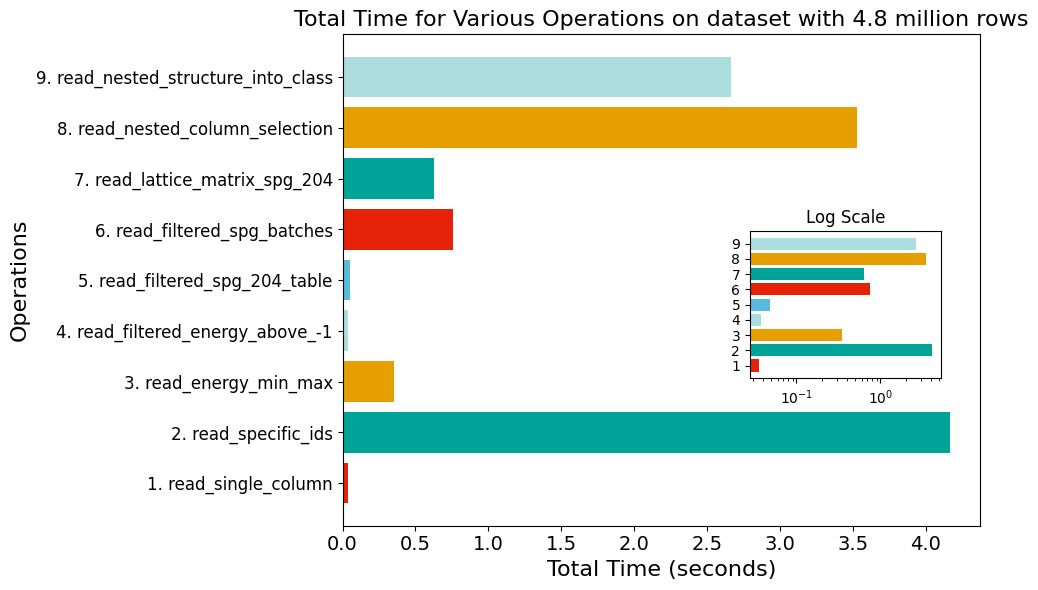

In [24]:
xlabel_size = 16
ylabel_size = 16
title_size = 16
xtick_size = 14
ytick_size = 12

inset_xtick_size = 10
inset_ytick_size = 10
inset_title_size = 12

labels = task_benchmark_dict["task_names"]
times = task_benchmark_dict["task_times"]
# Create the main plot with numbered x labels and an inset showing the same data on a log scale
fig, ax = plt.subplots(figsize=(10, 6))

# Number the labels
numbered_labels = [f"{i+1}. {label}" for i, label in enumerate(labels)]

# matplotlib_utils.set_palette('Cavalcanti1')
matplotlib_utils.set_palette("Darjeeling1_alt")
# matplotlib_utils.set_palette('Zissou1')
# matplotlib_utils.set_palette('AsteroidCity1')
# matplotlib_utils.set_palette('BottleRocket2')
colors = rcParams["axes.prop_cycle"].by_key()["color"]
# Main horizontal bar plotcolors[:len(times)]
# ax.barh(numbered_labels, times, color="#59b9de")
ax.barh(numbered_labels, times, color=colors[: len(times)])
ax.set_xlabel("Total Time (seconds)", fontsize=xlabel_size)
ax.set_ylabel("Operations", fontsize=ylabel_size)

ax.tick_params(axis="x", labelsize=xtick_size)
ax.tick_params(axis="y", labelsize=ytick_size)
ax.set_title(
    "Total Time for Various Operations on dataset with 4.8 million rows",
    fontsize=title_size,
)

# Inset plot with log scale and just the numbers
# ax_inset = inset_axes(ax, width="40%", height="30%", loc="center right")

ax_inset = inset_axes(
    ax,
    width="30%",
    height="30%",
    loc="center right",
    bbox_to_anchor=(-0.05, -0.05, 1, 1),
    bbox_transform=ax.transAxes,
)
ax_inset.barh(range(1, len(labels) + 1), times, color="#e52207")
ax_inset.barh(range(1, len(labels) + 1), times, color=colors[: len(times)])
ax_inset.set_xscale("log")
ax_inset.set_yticks(range(1, len(labels) + 1))  # Show just the numbers
ax_inset.set_yticklabels(range(1, len(labels) + 1), fontsize=inset_ytick_size)
ax_inset.set_title("Log Scale", fontsize=inset_title_size)

# Adjust layout and show the plot
plt.tight_layout()

plt.show()